In [1]:
import torch
import matplotlib.pyplot as plt

import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

from torchvision import datasets
from torchvision.transforms import ToTensor

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,         
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

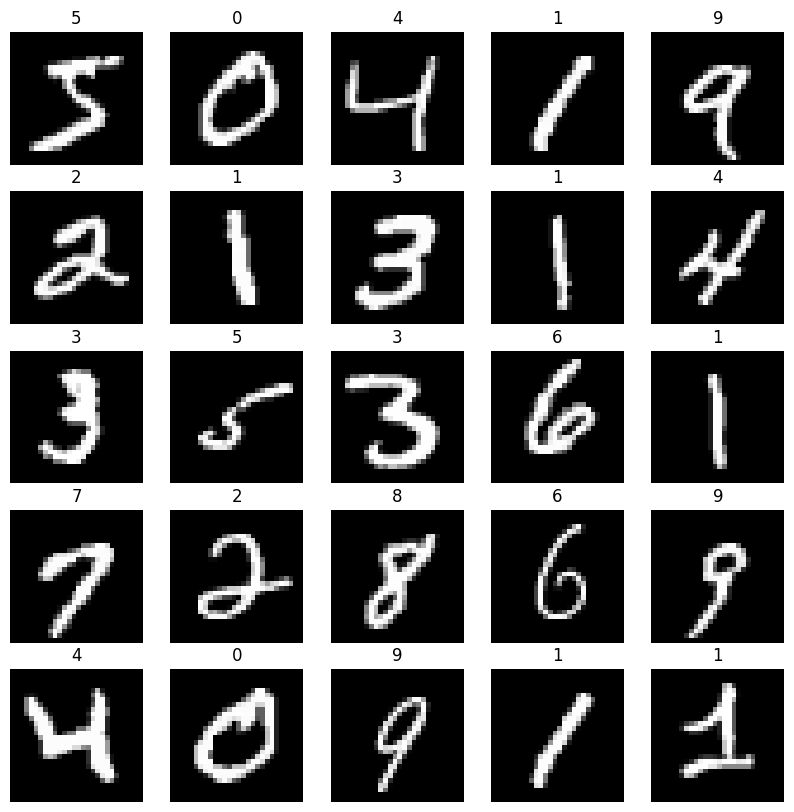

In [3]:
fig, axs = plt.subplots(5,5, figsize=(10,10))
for i,ax in enumerate (axs.flatten()):
    ax.imshow(train_data.data[i], cmap='gray') # visualize the image
    ax.set_title(train_data.targets[i].item()) # what it was supposed to be
    ax.set_axis_off()
plt.show()


In [4]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=32,
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=32, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f5d06d4b110>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f5d06d752b0>}

In [5]:
for image, label in loaders['test']:
    print(image.shape, label.shape)
    break

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [6]:
# here it is for demonstration purpose only, do not change here for a run result
# refer to the lower hyperparameter box for this
HIDDEN_WIDTH = 64
ACTIVATION = F.sigmoid

In [7]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784)
        )

    def forward(self, X):
        X = X.squeeze(1).flatten(-2, -1)
        z = self.encoder(X)
        X_hat = self.decoder(z)
        return X_hat


# Un autoencodeur ne fait pas de probabilités. On utilisera donc une MSELoss

In [8]:
s0 = train_data.data[0]/255.
net = Net()
prediction_s0 = net(s0)
prediction_s0

tensor([ 6.5768e-04, -2.2500e-02, -4.9343e-02,  2.6794e-02,  7.1482e-02,
         4.5659e-02,  3.8117e-02, -2.3896e-03, -1.2190e-03,  7.2076e-02,
        -2.1271e-02,  2.8047e-02, -5.9539e-02,  6.4041e-02, -2.4867e-02,
        -4.6498e-02,  7.8406e-03,  3.1867e-02, -5.7330e-02,  3.0218e-02,
        -3.7573e-02,  6.3416e-02,  4.1941e-02,  4.6715e-02,  1.8925e-02,
        -8.1162e-02, -5.2582e-02,  6.4889e-02, -1.2682e-02, -1.9306e-02,
        -6.3737e-02,  3.8459e-02,  7.2499e-02, -7.0165e-03, -1.9643e-03,
        -4.6418e-02, -4.4243e-02,  3.7676e-02,  4.4323e-02, -3.2286e-02,
         1.8094e-02, -2.0336e-03, -4.4057e-02,  2.9463e-02,  4.4350e-02,
         5.0999e-02,  2.1416e-02, -4.8834e-02, -2.1918e-03, -5.9340e-02,
         8.9882e-02, -2.9927e-02, -5.1074e-02,  2.7384e-02,  2.9927e-03,
         5.0809e-02,  2.6299e-02,  7.9776e-02, -3.6840e-02,  4.8618e-02,
        -6.7216e-02,  6.5964e-02,  1.0610e-02, -3.0727e-02, -5.2034e-02,
        -1.2831e-02,  1.3369e-02,  5.9608e-02,  3.2

In [9]:
# for convenience
def reset(net_class, criterion_class, optim_class, lr):
    net = net_class()
    criterion = criterion_class() # cross entropy loss
    optimizer = optim_class(net.parameters(), lr=lr)
    return net, criterion, optimizer

In [10]:
#from torch.autograd import Variable 
total_step = len(loaders['train'])

def train(num_epochs, loaders, net, optimizer, criterion):
    # Visualization stuff
    logs = {'train_losses':[], 'test_losses':[], 'accuracies':[], 'steps':[], 'test_steps':[]}
    step = 0
    
    # Learning stuff. Set the net to training mode:
    net.train()
    # Learning loop:
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']): # extracts batches of data using loaders
            # Compute loss
            output = net(images)
#            labels_onehot = F.one_hot(labels, num_classes=10)*1.
#            loss = torch.mean((output-labels_onehot)**2) # criterion(output, labels_onehot)

            # Flatten input images to (batch, 784)
            images_flat = images.squeeze(1).flatten(-2,-1)
            # Compute reconstruction loss between sortie et entrée
            loss = criterion(output, images_flat)

            # Compute gradient (backprop) and apply SGD
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()  # Adam
            step += 1

            # logging of training stuff
            logs['train_losses'].append(loss.item())
            logs['steps'].append(step) 
            
            # Testing and logging
            if ((i+1) % 200 == 0) or step==1 : # perform test step
                test_update_logs(logs, net, criterion, i, step, epoch, num_epochs)

    return logs 

In [11]:
def test_update_logs(logs, net, criterion, i, step, epoch, num_epochs):
    test_loss, acc = test(net, criterion)
    print ('Epoch [{}/{}], Step [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.4f}' 
            .format(epoch + 1, num_epochs, i + 1, total_step, test_loss, acc))
    logs['test_losses'].append(test_loss)
    logs['accuracies'].append(acc)
    logs['test_steps'].append(step)
    # if ((i+1)%600)==0:
    #     plot(logs)
    if epoch == num_epochs - 1 and i == total_step - 1:
        print(
            'Final Epoch [{}/{}], Final Step [{}/{}], Final Test Loss: {:.4f}, Final Test Accuracy: {:.4f}'
            .format(epoch + 1, num_epochs, i + 1, total_step, test_loss, acc)
        )
        plot(logs)

def test(net, criterion):
    net.eval()    
    with torch.no_grad():
        total_loss = []
        for images, _ in loaders['test']:   
            output = net(images)
            images_flat = images.squeeze(1).flatten(-2, -1)
            loss = criterion(output, images_flat)
            total_loss.append(loss.item())

    return np.mean(total_loss), 0.0


In [12]:
def plot(logs):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    ax1.plot(logs['steps'], logs['train_losses'], label="train loss")
    ax1.plot(logs['test_steps'], logs['test_losses'], label="test loss")
    ax1.set_yscale('log')
    ax1.set_title("Losses (log scale)")
    ax1.legend()
    ax2.plot(logs['test_steps'], logs['accuracies'])
    ax2.set_title("Accuracy")
    ax2.set_ylim(0,1)
    plt.show()

In [13]:
# Hyperparameter box - change things here to launch a new run!
HIDDEN_WIDTH = 64
ACTIVATION = F.relu
LEARNING_RATE = 0.005
OPTIMIZER = torch.optim.Adam
CRITERION = nn.MSELoss

In [15]:
NUM_EPOCHS = 100
LEARNING_RATE = 0.001

net, criterion, optimizer = reset(Net, nn.MSELoss, torch.optim.Adam, lr=LEARNING_RATE)
logs = train(NUM_EPOCHS, loaders, net, optimizer, criterion)

Epoch [1/100], Step [1/1875], Test Loss: 0.1136, Test Accuracy: 0.0000
Epoch [1/100], Step [200/1875], Test Loss: 0.0358, Test Accuracy: 0.0000
Epoch [1/100], Step [400/1875], Test Loss: 0.0274, Test Accuracy: 0.0000
Epoch [1/100], Step [600/1875], Test Loss: 0.0229, Test Accuracy: 0.0000
Epoch [1/100], Step [800/1875], Test Loss: 0.0202, Test Accuracy: 0.0000
Epoch [1/100], Step [1000/1875], Test Loss: 0.0185, Test Accuracy: 0.0000
Epoch [1/100], Step [1200/1875], Test Loss: 0.0172, Test Accuracy: 0.0000
Epoch [1/100], Step [1400/1875], Test Loss: 0.0164, Test Accuracy: 0.0000
Epoch [1/100], Step [1600/1875], Test Loss: 0.0154, Test Accuracy: 0.0000
Epoch [1/100], Step [1800/1875], Test Loss: 0.0148, Test Accuracy: 0.0000
Epoch [2/100], Step [200/1875], Test Loss: 0.0140, Test Accuracy: 0.0000
Epoch [2/100], Step [400/1875], Test Loss: 0.0136, Test Accuracy: 0.0000
Epoch [2/100], Step [600/1875], Test Loss: 0.0131, Test Accuracy: 0.0000
Epoch [2/100], Step [800/1875], Test Loss: 0.012

Erreur de reconstruction (MSE) : 0.006907466799020767


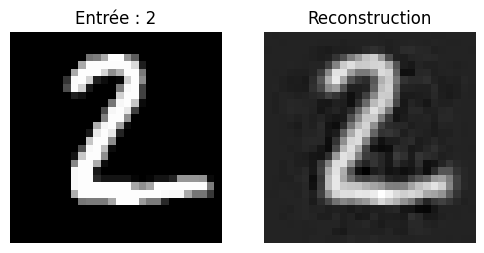

In [ ]:
import matplotlib.pyplot as plt

# chercher un "2" dans le jeu de test
for img, label in test_data:
    if label == 2:
        image_2 = img
        break

net.eval()
with torch.no_grad():
    reconstruction = net(image_2.unsqueeze(0))

reconstruction_img = reconstruction.view(28, 28)

original = image_2.view(1, -1)
loss = criterion(reconstruction, original)
print("Erreur de reconstruction (MSE) :", loss.item())



plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.imshow(image_2.squeeze(), cmap='gray')
plt.title("Entrée : 2")
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstruction_img, cmap='gray')
plt.title("Reconstruction")
plt.axis('off')

plt.show()

# learning rate at 0,001
# 0,0256 avec 2 couches et 30 epoch
# 0,0139 pui 0,017 avec 4 couches et 20 epoch
# 0,018 avec 4 couches et 30 epoch
# 0,01 avec 3 couches et 20 epoch
# 0,00836 avec 3 couches et 30 epoch
# 3 couches / 50 epoch : 0,0076 
# 3 couches / 100 epoch :  0.0069

# Avec learnin rate 0.0001 / 3 couches / 30 epoch : 0,01
# Avec learnin rate 0.0001 / 3 couches / 50 epoch : 0,0105